### Code to evaluate performance on chess dataset

In [1]:
from datasets import load_from_disk

In [2]:
# Load the data from results/arithmetic/probe/base10
activation_dataset = load_from_disk("../../../results/arithmetic/probe/base10")


In [3]:
# Print the column names
print(activation_dataset.column_names)

['prompt', 'llm_response', 'mlp_activations', 'attention_activations', 'residual_activations', 'expr', 'base']


In [4]:
# Drop the activation columns
activation_dataset = activation_dataset.remove_columns(['mlp_activations', 'attention_activations'])

In [13]:
# Print the first 5 rows of the dataset
print("First 5 rows of the dataset:")
for i in range(5):
    print(activation_dataset[i])
    #print(f"\nRow {i}:")

First 5 rows of the dataset:
{'prompt': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a mathematician. Assuming that all numbers are in base-10, where the digits are "0123456789".<|eot_id|><|start_header_id|>user<|end_header_id|>\n### Question: \nWhat is 76+14? End the response with the result in "\\boxed{result}".\n### Answer: \n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n', 'llm_response': 'system\nYou are a mathematician. Assuming that all numbers are in base-10, where the digits are "0123456789".user\n### Question: \nWhat is 76+14? End the response with the result in "\\boxed{result}".\n### Answer: \nassistant\nTo find the result of 76+14, I\'ll add the two numbers together:\n\n76 + 14 = 90\n\nSo the result is: \n\\boxed{90}', 'expr': '76+14', 'base': 10}
{'prompt': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a mathematician. Assuming that all numbers are in base-10, where the digits are "0123456789".<|eot_id|><|start_h

In [5]:
# Evaluate the model responses an accuracy
import hashlib
import re
import sys

import numpy as np


def unescape(str):
    placeholder = "<TMP>"
    assert placeholder not in str
    return str.replace("\\\\n", placeholder).replace("\\n", "\n").replace(placeholder, "\\n").replace("\\\\r", placeholder).replace("\\r", "\r").replace(placeholder, "\\r")


def parse_output(output):
    if len(output) == 0:
        return "FAILED"

    output_hash = hashlib.md5(output.encode("utf-8")).hexdigest()
    if output_hash in {"a7994fde4fba7d27500e6f03008abd7c"}:
        return "FAILED"

    output = output.replace(",", "").replace("С", "C")

    if (match := re.search("^[0-9A-Z]+$", output)) is not None:
        return output

    output = output.rstrip("\n$ `")
    if output.endswith("\n"):
        output = output[:-1]
    output = output.replace("\\text{", "")

    boxed_regex = r"boxed{(\\text{)?(result=)?([0-9A-Z]+(_{?[0-9]+}?)?\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)?\s*=\s*)?(0x)?([0-9A-Za-f \\.]+)(_ ?{?(base-)?([0-9]+|ten)}?)?}?(_{?([0-9]+|ten)}?)?}"
    get_result_from_boxed_regex = lambda match: match[-6].replace(" ", "").replace("\\", "")
    # match all \boxed{...} but also make sure there's only one match
    match = re.findall(boxed_regex, output)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.split("\n")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.rstrip(" .").split(".")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    if (match := re.search(r"\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*\+\s*\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*=\s*\\boxed{([0-9A-Z]+)}(_{?[0-9]+}?)?\.?$", last_line)) is not None:
        return match.groups()[-2]

    if (match := re.search(r"\\boxed{([0-9A-Z]+)_{?[0-9]+}?\s*=\s*[0-9A-Z]+_{?10}?}\$?\.?$", last_line)) is not None:
        return match.groups()[0]

    if (match := re.search(r"\$?[0-9A-Z]+(_{?[0-9]+}?)\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)\s*=\s*(0x)?([0-9A-Z]+)(_{?[0-9]+}?)\$?( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-3]

    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?,?( and| or| =) \$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?\.?$", output)) is not None:
        return match.groups()[2]
    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?,?( and| or| =) \$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?\.?$", output)) is not None:
        return match.groups()[-1]
    # \boxed{207}_{10}$ which in base-11 is $\boxed{18A}$.
    if (match := re.search(r"\\boxed{[0-9A-Z]+}_\{10\}\$? which in base-[0-9]+ is \$?\\boxed{(0x)?([0-9A-Z]+)}\$?\.?$", output)) is not None:
        return match.groups()[-1]
    # 39 + 31 = 5A\boxed{}
    if (match := re.search(r"[0-9]+\s*\+\s*[0-9]+\s*=\s*([0-9A-Z]+)\\boxed\{\}\.?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result}\n62
    if (match := re.search(r"\\boxed{result}\s*(\n|=)?\s*([0-9A-Z+*^. ]+=\s*)?([0-9A-Z.]+)\$?\.?\**}?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result: 62}
    if (match := re.search(r"\\boxed{result: ([0-9A-Z]+)}$", output)) is not None:
        return match.groups()[0]

    match = re.findall(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*(0x)?([0-9A-Z]+)", last_line)
    if len(match) == 1:
        return match[0][1]

    match_after_semicolon = r"\s+((\n|[ 0-9A-Z*^])+(\+(\n|[ 0-9A-Z*^])+)+(=|-+|_+)\s*)*([0-9A-Z]+)\s*(\(?(in )?base-[0-9]+\)?)?(, which [^,.]+)?(\s*\([^()]+\))?\.?$"
    if (match := re.search(r"\n([0-9A-Z]+)$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z]+)\"?( base-[0-9]+)?(, (or|since) [^.]+)?( \([^()]+\))?\.$", output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r" in base-[0-9]+: \$?([0-9A-Z]+)\$?\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" the base-[0-9]+ sum: ([0-9A-Z]+)\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result in base-[0-9]+ is ([0-9A-Z]+), which is equal to [0-9 *^+()]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"the sum of [0-9A-Z]+ and [0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"the result of [0-9A-Z]+\s*\+\s*[0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+( in base-[0-9]+)?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"in base-10 is \$?[0-9]+\$?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*([0-9A-Z]+)( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"we can simply write the result as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"which can be written as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"(which gives|giving) us the( base-[0-9]+)? number ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the final result is simply the sum of the tens and ones places: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result is simply the combination of these two sums: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"we have ([0-9A-Z]+) in base-[0-9]+ as the (final answer for|result of|sum of) [0-9A-Z]+ (\+|and) [0-9A-Z]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"we (have|get|end up with) ([0-9A-Z]+)( in base-[0-9]+)? as the( final)? (result|answer|sum)( in base-[0-9]+)?\.$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"(=| is) \"?([0-9A-Z]+)\"?\s*(\s+\(?(in )?base-[0-9]+\)?)?\.?$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"( final)?( base-[0-9]+)? (result|answer|sum)( in base-[0-9]+)?( is)?( simply)?( of)?( as)?:?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we get:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we can add the two numbers in base-[0-9]+:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[tT]he combination of these sums:\s+([0-9A-Z]+)(\(in base-[0-9]+\))?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"(Result|Answer)( is)?:?\s+([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"The decimal equivalent of \$?([0-9A-Z]+)\$? is therefore \$?[0-9A-Z]+\$?\.?$", output)) is not None:
        return match.groups()[0]
    if (match := re.search(r"(T|t)he final (result|answer) is:?\s+([0-9A-Z ]+\s*\+\s*[0-9A-Z ]+\s*(=|-+)+\s*)?([0-9A-Z ]+)(\(in base-[0-9]+\))?\.?\**$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z ]+)\"?(, or [^,.]+)?\.$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r"( |(\n))([0-9A-Z]+) \(?in base-[0-9]+\)?\.$", output)) is not None:
        return match.groups()[-1]

    #print("Failed to parse output:", output)
    #print(output_hash)
    return "FAILED"


def get_label(expr, base):
    lhs, rhs = expr.split("+")
    lhs_base10 = int(lhs, base)
    rhs_base10 = int(rhs, base)
    sum_base10 = lhs_base10 + rhs_base10
    return np.base_repr(sum_base10, base)


In [6]:
base = 10
correct = total = 0
incorrect_instances = []
failed_instances = []

labels = []
for i in range(len(activation_dataset)):
    model_answer = activation_dataset[i]['llm_response'].split("assistant")[1].strip()
    expr = activation_dataset[i]['expr']
    
    pred = parse_output(model_answer).upper()
    label = get_label(expr, base)
    if pred == "FAILED":
        failed_instances.append(activation_dataset[i])
        labels.append("FAILED")
        continue
    if label == pred:
        correct += 1
        labels.append(1)
    else:
        incorrect_instances.append(activation_dataset[i])
        labels.append(0)
    
    total += 1

print(f"Accuracy: {correct} / {total} = {correct / total}")

Accuracy: 982 / 999 = 0.982982982982983


In [23]:
# Create a pca plot of the activations for the correct, failed, and incorrect instances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to numpy array and convert strings to numbers
labels_array = np.array([1 if x == '1' else 0 if x == '0' else -1 if x == 'FAILED' else x for x in labels])

# Use boolean indexing to get indices 
correct_indices = np.where(labels_array == 1)[0]
print(len(correct_indices))
failed_indices = np.where(labels_array == -1)[0]
incorrect_indices = np.where(labels_array == 0)[0]
print(len(incorrect_indices))

# Sample a smaller subset from each category for visualization
# n_samples = min(1000, len(correct_indices), len(failed_indices), len(incorrect_indices))
# correct_sample = np.random.choice(correct_indices, size=n_samples, replace=False)
# #failed_sample = np.random.choice(failed_indices, size=n_samples, replace=False) 
# incorrect_sample = np.random.choice(incorrect_indices, size=n_samples, replace=False)
# print(len(correct_sample))
# print(len(incorrect_sample))
# Get activations for sampled indices for layer 21
layer = 21
print(len(activation_dataset[0]['residual_activations']))
sampled_indices = np.concatenate([correct_indices, incorrect_indices])
print(len(sampled_indices))
sampled_activations = np.vstack([activation_dataset[int(i)]['residual_activations'][layer] for i in sampled_indices])

# Perform PCA on sampled data
pca = PCA(n_components=2)
activations_2d = pca.fit_transform(sampled_activations)

# Split back into categories
correct_points = activations_2d[correct_indices]
incorrect_points = activations_2d[incorrect_indices]

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(correct_points[:,0], correct_points[:,1], c='green', label='Correct', alpha=0.6)
plt.scatter(incorrect_points[:,0], incorrect_points[:,1], c='red', label='Incorrect', alpha=0.6)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)
plt.show()






982
17
32
999


IndexError: index 999 is out of bounds for axis 0 with size 999

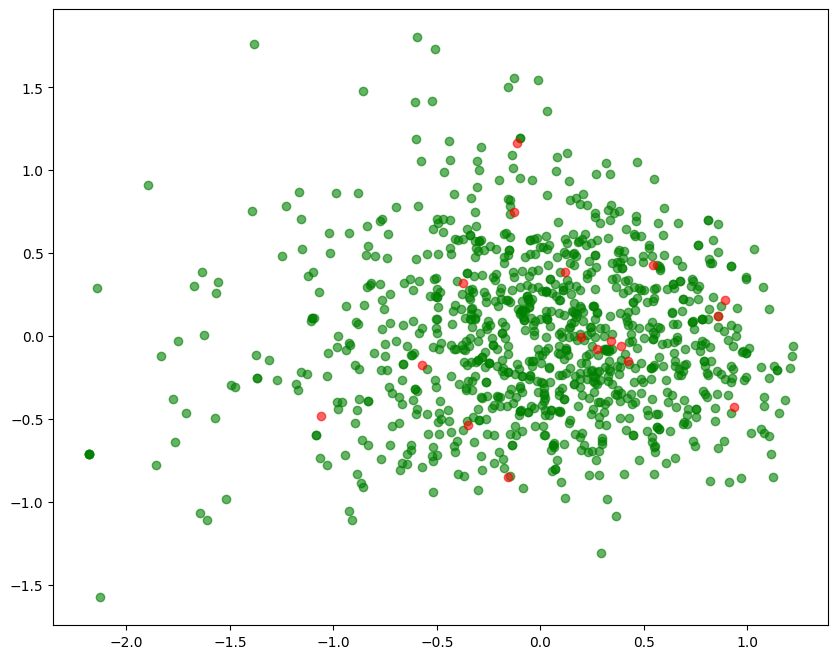

In [24]:
# Perform PCA on sampled data
pca = PCA(n_components=2)
activations_2d = pca.fit_transform(sampled_activations)

# Calculate the number of samples from each category
n_correct = len(correct_indices)
n_incorrect = len(incorrect_indices)

# Split the PCA results based on the original order
# The first n_correct points are from correct samples
correct_points = activations_2d[:n_correct]
# The remaining points are from incorrect samples
incorrect_points = activations_2d[n_correct:]

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(correct_points[:,0], correct_points[:,1], c='green', label='Correct', alpha=0.6)
plt.scatter(incorrect_points[:,0], incorrect_points[:,1], c='red', label='Incorrect', alpha=0.6)

In [29]:
for row in failed_instances:
    print(row['llm_response'].split("assistant")[1].strip())

To find the sum of 28 and 85, we can add the digits in the ones place (8+5) and the digits in the tens place (2+8). 

In the ones place, 8+5 = 13, but since we're working in base-10, we only keep the last digit, which is 3. 

In the tens place, 2+8 = 10, so we keep the digit 0 and carry over the 1.

Combining the results, we get 103.


In [31]:
for row in incorrect_instances:
    print('-'*100)
    print(row['llm_response'].split("assistant")[1].strip())

----------------------------------------------------------------------------------------------------
To solve this, we'll add the numbers 99 and 77.

First, add the rightmost digits (9 and 7):
9 + 7 = 16

Since 16 is a two-digit number, we'll write down the 6 and carry over the 1 to the next column.

Next, add the next digits (9 and 7) along with the carried over 1:
9 + 7 + 1 = 17

Write down the 7 and carry over the 1 to the next column.

Finally, add the leftmost digits (no digits to add since there are no more columns):
1 (carried over) = 1

Now, combine the results from each step: 177.

So, 99 + 77 = 177.

\boxed{177}
----------------------------------------------------------------------------------------------------
To calculate 73 + 47, we need to add the numbers together:

7 + 7 = 14
30 + 40 = 70
14 + 70 = 84

So the result is 84.

\boxed{84}
----------------------------------------------------------------------------------------------------
To calculate 99+88, we can simply add

In [15]:
# Load all the alpha datasets from the results/arithmetic/intervention/liref directory for all bases
# 

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk


def load_alpha_datasets(base, base_dir, expressions):
    """Load datasets for all alpha values for a specific base."""
    # Define the directory for this base's intervention results
    base_dir_path = os.path.join(base_dir, f"base{base}")
    
    # Find all alpha directories
    alpha_dirs = glob.glob(os.path.join(base_dir_path, "*"))
    print(f"Found {len(alpha_dirs)} alpha directories for base {base}")
    
    # Create dictionaries to store results for each alpha
    alpha_results = {}
    total_counts = {}
    valid_counts = {}
    
    for alpha_dir in sorted(alpha_dirs):
        # Extract alpha value from directory name
        alpha_value = os.path.basename(alpha_dir).replace("alpha", "")
        print(alpha_value)
        try:
            # Load the dataset
            dataset = load_from_disk(alpha_dir)
            print(f"Base {base}, Alpha {alpha_value}: Dataset size = {len(dataset)}")
            
            # Calculate accuracy
            correct = total = 0
            valid_count = 0
            dataset_size = len(dataset)
            for i in range(len(expressions)):
                model_answer = dataset[i]['intervention_response'].split("assistant")[1].strip()
                expr = expressions[i]
                print(i)
                pred = parse_output(model_answer).upper()
                label = get_label(expr, base)
                if pred != "FAILED":
                    valid_count += 1
                    if label == pred:
                        correct += 1
                    total += 1
            
            accuracy = correct / total if total > 0 else 0
            alpha_results[float(alpha_value)] = accuracy
            total_counts[float(alpha_value)] = dataset_size
            valid_counts[float(alpha_value)] = valid_count
            print(f"Base {base}, Alpha {alpha_value}: Accuracy = {accuracy:.4f} ({correct}/{total}), Valid: {valid_count}/{dataset_size}")
        except Exception as e:
            print(f"Error processing base {base}, alpha {alpha_value}: {e}")
    
    return alpha_results, total_counts, valid_counts

def plot_results_for_base(base, results_df):
    """Plot accuracy and valid response counts for a specific base."""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot accuracy line on the first y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Alpha Value')
    ax1.set_ylabel('Accuracy', color=color)
    line1 = ax1.plot(results_df['Alpha'], results_df['Accuracy'], marker='o', color=color, label='Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Add second y-axis for valid counts
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Valid Responses', color=color)
    line2 = ax2.plot(results_df['Alpha'], results_df['Valid'], marker='s', color=color, label='Valid Responses')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add a combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')
    
    plt.title(f'Accuracy vs Alpha for Base {base} Arithmetic with Valid Response Counts')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return fig

# Define the base directory for intervention results
base_dir = "../../../results/arithmetic/intervention/liref"

# Define the bases to process
bases = [8, 9, 10, 11, 16]


# Process each base
for base in bases:
    print(f"\nProcessing base {base}...")
    # Load expressions from the corresponding base file
    base_file_path = f"../../../inputs/arithmetic/data/base{base}.txt"
    try:
        with open(base_file_path, 'r') as f:
            expressions = [line.strip() for line in f if line.strip()]
        print(f"Loaded {len(expressions)} expressions from {base_file_path}")
    except FileNotFoundError:
        print(f"File not found: {base_file_path}, using expressions from activation dataset")
        expressions = activation_dataset['expr']
    
    # Load datasets and calculate metrics
    alpha_results, total_counts, valid_counts = load_alpha_datasets(base, base_dir, expressions)
    
    if not alpha_results:
        print(f"No results found for base {base}, skipping.")
        continue
    
    # Convert results to DataFrame for easier plotting
    results_df = pd.DataFrame({
        'Alpha': list(alpha_results.keys()),
        'Accuracy': list(alpha_results.values()),
        'Total': list(total_counts.values()),
        'Valid': list(valid_counts.values())
    })
    results_df = results_df.sort_values('Alpha')
    
    # Plot the results
    fig = plot_results_for_base(base, results_df)
    
    print(f"Results for base {base}:")
    print(results_df)



Processing base 8...
Loaded 1000 expressions from ../../../inputs/arithmetic/data/base8.txt
Found 7 alpha directories for base 8
-0.05
Base 8, Alpha -0.05: Dataset size = 1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
2

KeyboardInterrupt: 

### Notes
- This graph is somewhat strange. The model's ability to answer doesn't decline by that much but increasing the memorization strength does really collapse model's ability to do arithmetic
- Increasing along reasoning boundary causes the model to collapse less quickly.
- TODO: More careful output analysis

In [ ]:

def analyze_specific_base_alpha(base, alpha, base_dir="../../../results/arithmetic/intervention/liref"):
    """
    Analyze a specific base and alpha combination using the existing functions.
    
    Args:
        base: Integer base to analyze (e.g., 8, 10, 16)
        alpha: Float alpha value to analyze (e.g., 0.05, 0.10)
        base_dir: Base directory containing the results
        
    Returns:
        Analysis statistics for the specified base and alpha
    """
    print(f"Analyzing base {base}, alpha {alpha}...")
    alpha_str = f"{alpha:.2f}"

    # Load expressions from the corresponding base file
    base_file_path = f"../../../inputs/arithmetic/data/base{base}.txt"
    try:
        with open(base_file_path, 'r') as f:
            expressions = [line.strip() for line in f if line.strip()]
        print(f"Loaded {len(expressions)} expressions from {base_file_path}")
    except FileNotFoundError:
        print(f"File not found: {base_file_path}")
        return None
    
    # Define the directory for this specific alpha
    base_dir_path = os.path.join(base_dir, f"base{base}")
    alpha_dir = os.path.join(base_dir_path, f"{alpha_str}")
    
    if not os.path.exists(alpha_dir):
        print(f"Directory not found: {alpha_dir}")
        return None
    
    # Create a temporary list with just this alpha directory
    temp_alpha_dirs = [alpha_dir]
    
    # Use the existing load_alpha_datasets function, but with a try/except around each example
    def load_single_alpha_dataset(alpha_dir, expressions):
        alpha_value = os.path.basename(alpha_dir).replace("alpha", "")
        print(f"Processing alpha: {alpha_value}")
        
        try:
            # Load the dataset
            dataset = load_from_disk(alpha_dir)
            dataset_size = len(dataset)
            print(f"Base {base}, Alpha {alpha_value}: Dataset size = {dataset_size}")
            
            # Calculate accuracy with added safety
            correct = total = 0
            valid_count = 0
            
            for i in range(min(len(expressions), dataset_size)):
                try:
                    print(f"Processing example {i}...")
                    model_answer = dataset[i]['intervention_response'].split("assistant")[1].strip()
                    expr = expressions[i]

                    if i == 212:
                        print(model_answer)
                        print(expr)
                        print(parse_output(model_answer).upper())
                        print(get_label(expr, base))
                    
                    # Use existing parse function but with try/except
                    try:
                        pred = parse_output(model_answer).upper()
                        print(f"Example {i} prediction: {pred}")
                    except Exception as e:
                        print(f"Error parsing example {i}: {e}")
                        pred = "FAILED"
                    
                    # Use existing label function with try/except
                    try:
                        label = get_label(expr, base)
                    except Exception as e:
                        print(f"Error getting label for example {i}: {e}")
                        label = "UNKNOWN"
                    
                    if pred != "FAILED":
                        valid_count += 1
                        if label == pred:
                            correct += 1
                        total += 1
                except Exception as e:
                    print(f"Error processing example {i}: {e}")
                    continue
            
            # Calculate metrics
            accuracy = correct / total if total > 0 else 0
            results = {
                "alpha": float(alpha_value),
                "accuracy": accuracy,
                "correct": correct,
                "total": total,
                "valid": valid_count,
                "dataset_size": dataset_size
            }
            
            print(f"Base {base}, Alpha {alpha_value}: Accuracy = {accuracy:.4f} ({correct}/{total}), Valid: {valid_count}/{dataset_size}")
            return results
            
        except Exception as e:
            print(f"Error processing alpha {alpha_value}: {e}")
            return None
    
    # Process this single alpha value
    results = load_single_alpha_dataset(alpha_dir, expressions)
    
    if results:
        # Create a small DataFrame for just this result
        df = pd.DataFrame({
            'Base': [base],
            'Alpha': [results['alpha']],
            'Accuracy': [results['accuracy']],
            'Correct': [results['correct']],
            'Valid': [results['valid']],
            'Total': [results['dataset_size']]
        })
        
        print("\nAnalysis Results:")
        print(df)
        
        return results
    else:
        print(f"Failed to analyze base {base}, alpha {alpha}")
        return None

# Example usage:
result = analyze_specific_base_alpha(base=8, alpha=0.10)

Analyzing base 8, alpha 0.1...
Loaded 1000 expressions from ../../../inputs/arithmetic/data/base8.txt
Processing alpha: 0.10
Base 8, Alpha 0.10: Dataset size = 1000
Processing example 0...
Example 0 prediction: 23
Processing example 1...
Example 1 prediction: 80
Processing example 2...
Example 2 prediction: 14
Processing example 3...
Example 3 prediction: 105
Processing example 4...
Example 4 prediction: 23
Processing example 5...
Example 5 prediction: 124
Processing example 6...
Example 6 prediction: 110
Processing example 7...
Example 7 prediction: 16
Processing example 8...
Example 8 prediction: 71
Processing example 9...
Example 9 prediction: 57
Processing example 10...
Example 10 prediction: 117
Processing example 11...
Example 11 prediction: 106
Processing example 12...
Example 12 prediction: 85
Processing example 13...
Example 13 prediction: 27
Processing example 14...
Example 14 prediction: 50
Processing example 15...
Example 15 prediction: 84
Processing example 16...
Example 1

KeyboardInterrupt: 